In [4]:
import scipy.stats as st
import numpy as np
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt
from IPython.display import Image

## Что можно предположить
Во-первых, максимум информации не всегда соответствует максимуму неопределенности.

Во-вторых, на криптобиржах активы зачастую торгуются в формате 24/7, поэтому единственное, что может повлиять на крипторынок в понедельник утром - это наличие ликвидности. Таким образом, будет странно если мы найдем значительное увеличение спреда.

In [40]:
datapath = glob('data\**')
names = [path.split('\\')[1].split('.')[0] for path in datapath]
dataset = [pd.read_csv(path) for path in datapath]
dataset[0].head()

,Time_utc,BidAskSpread_bp,MidPrice_Open,MidPrice_High,MidPrice_Low,MidPrice_Close
0,2021-08-30 05:43:00,4.655235,479874.66,480002.94,479821.78,479821.78
1,2021-08-30 05:44:00,4.818394,479821.78,480077.75,479810.12,479919.80
2,2021-08-30 05:45:00,4.490494,479919.80,479916.38,479613.00,479632.38
3,2021-08-30 05:46:00,4.492499,479632.38,479746.94,479461.66,479461.66
4,2021-08-30 05:47:00,4.318956,479461.66,480166.62,479450.44,479977.20


## Spreads


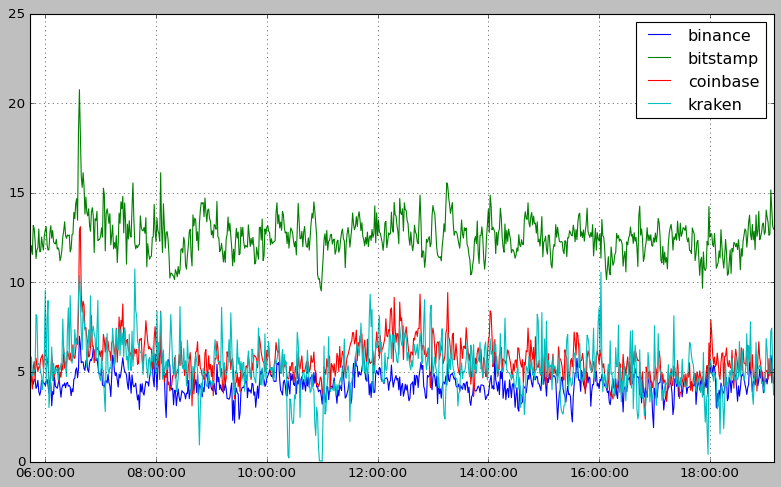

,binance,bitstamp,coinbase,kraken
count,807.000000,807.000000,807.000000,807.000000
mean,4.336654,12.559742,5.642515,5.294033
std,0.640239,1.071596,1.061232,1.446216
min,1.896324,9.522311,2.363423,0.020801
25%,3.967952,11.935809,4.957972,4.514133
50%,4.317451,12.523335,5.571186,5.186123
75%,4.714724,13.078948,6.185260,6.072928
max,6.995459,20.750510,13.101630,10.749858


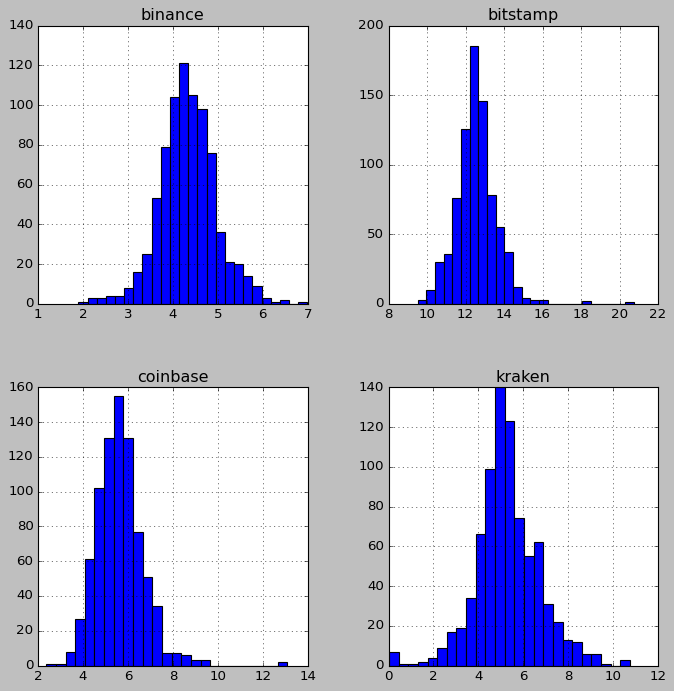

In [21]:
# preparing dataframe
spreads = pd.DataFrame()
for i in range(len(names)):
    spreads[names[i]] = dataset[i].BidAskSpread_bp
    #spreads[names[i]] = dataset[i].BidAskSpread_bp * 0.5 * (dataset[i].MidPrice_High + dataset[i].MidPrice_Low) / 10000
spreads['Time_utc'] = dataset[0].Time_utc
spreads.index = pd.to_datetime(spreads['Time_utc'])

# plotting
plt.style.use('classic')
plt.figure(figsize=(12,7))
for name in names:
    plt.plot(spreads.index, spreads[name].values, label = f'{name}')
plt.legend()
plt.grid()
plt.show()

spreads.hist(bins = 25, figsize=(10,10))
spreads.describe()

### $Разделим\ данные\ на\ два\ батчи\ длительностью\ в\ 60\ минут.$

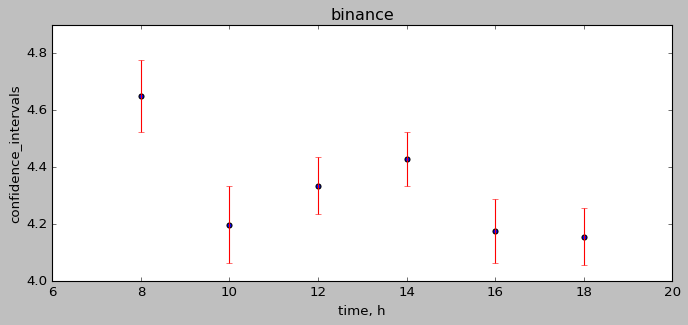

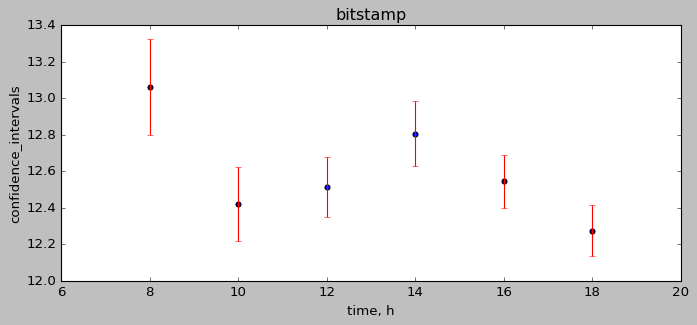

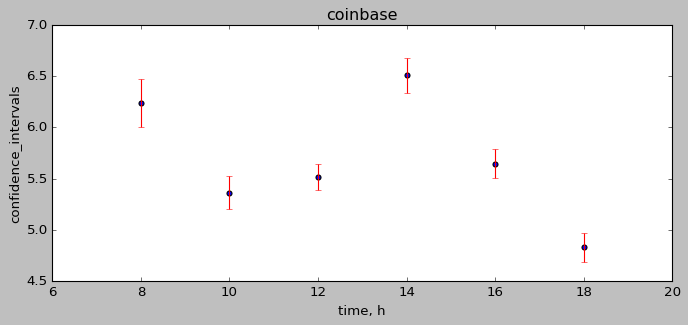

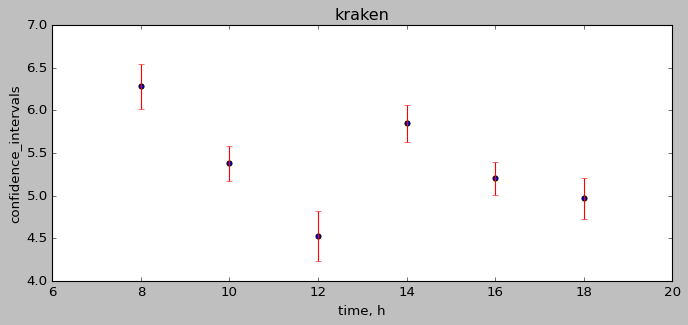

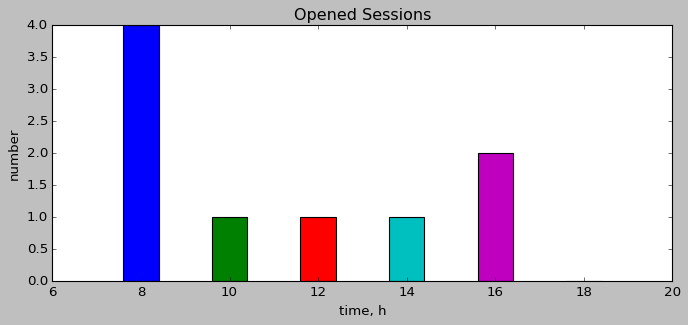

In [44]:
T = 120
samples = [spreads.iloc[T*i:T*(i+1)] for i in range(spreads.shape[0]//T)]

for name in names:
    plt.figure(figsize=(10,4))
    plt.title(name)

    for i in range(len(samples)):
        data = samples[i][name]
        mean = data.mean()
        interval = st.norm.interval(confidence=0.95, loc=mean, scale=st.sem(data.values))
        plt.errorbar((i+1)*2+6, mean, xerr=0.0, yerr=(interval[1]-interval[0])/2, c='red')
        plt.scatter((i+1)*2+6, mean, marker='o')
        plt.ylabel("confidence_intervals")
        plt.xlabel("time, h")
    plt.show()

session_number = [4, 1, 1, 1, 2, 0]
plt.figure(figsize=(10,4))
plt.title('Opened Sessions')
for i in range(len(session_number)):
    plt.bar((i+1)*2+6, session_number[i])
    plt.ylabel("number")
    plt.xlabel("time, h")
plt.show()

## Вывод
В спредах не обнаружились статистически значимые отклонения в период с 6:00 до 8:00 по UTC.
Однако видны всплески спреда, которые я бы скорее связывал с началом различных торговых сессий, многие из которых начинаются и заканчиваются в данных временных промежутках. Это приводит к смене игроков на рынке и нестабильности в ликвидности.

В любом случае, данных по одному торговому дню совершенно не достаточно, чтобы подтвердить начальную гипотезу.

## Price ranges

array([[<AxesSubplot: title={'center': 'binance'}>,
        <AxesSubplot: title={'center': 'bitstamp'}>],
       [<AxesSubplot: title={'center': 'coinbase'}>,
        <AxesSubplot: title={'center': 'kraken'}>]], dtype=object)

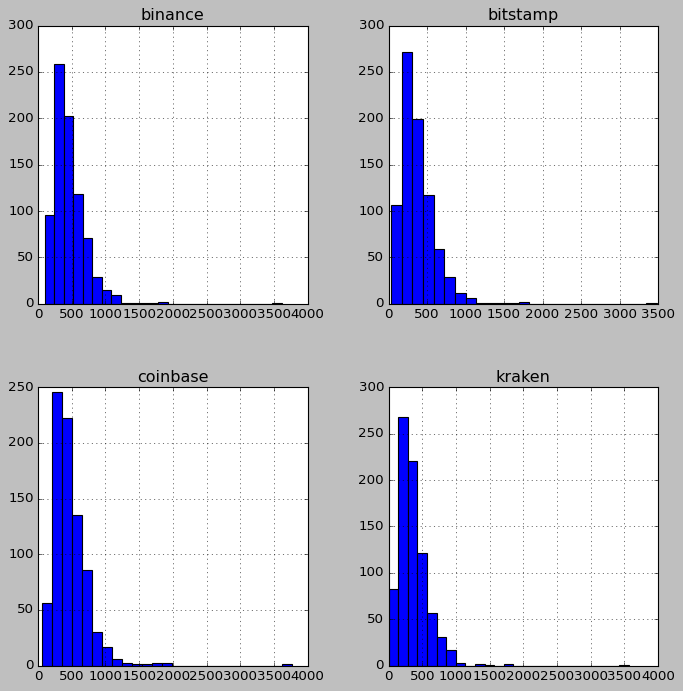

In [8]:
price_ranges = pd.DataFrame()
for i in range(len(names)):
    price_ranges[names[i]] = dataset[i]['MidPrice_High'] - dataset[i]['MidPrice_Low']
price_ranges.index = pd.to_datetime(dataset[0]['Time_utc'])

price_ranges.hist(bins = 25, figsize=(10,10))

### $Так\ как\ размах\ цены\ не\ может\ быть\ нуля,\ то\ логично\ логарифмировать\ значения$

binance 

Normal price range ===============
Shapiro_Wilk p-value = 3.22737663410917e-31,   Pearson p-value = 2.9921307632065456e-153
Log range ========================
Shapiro_Wilk p-value = 0.026415059342980385,   Pearson p-value p-value = 0.012246466133531255 

bitstamp 

Normal price range ===============
Shapiro_Wilk p-value = 6.09450151286223e-32,   Pearson p-value = 5.904255634820085e-159
Log range ========================
Shapiro_Wilk p-value = 0.03332506865262985,   Pearson p-value p-value = 0.00680187644276319 

coinbase 

Normal price range ===============
Shapiro_Wilk p-value = 2.0556577360428537e-31,   Pearson p-value = 9.67862057772224e-153
Log range ========================
Shapiro_Wilk p-value = 0.03130635991692543,   Pearson p-value p-value = 0.009703622784176977 

kraken 

Normal price range ===============
Shapiro_Wilk p-value = 1.0,   Pearson p-value = nan
Log range ========================
Shapiro_Wilk p-value = 1.0,   Pearson p-value p-value = nan 



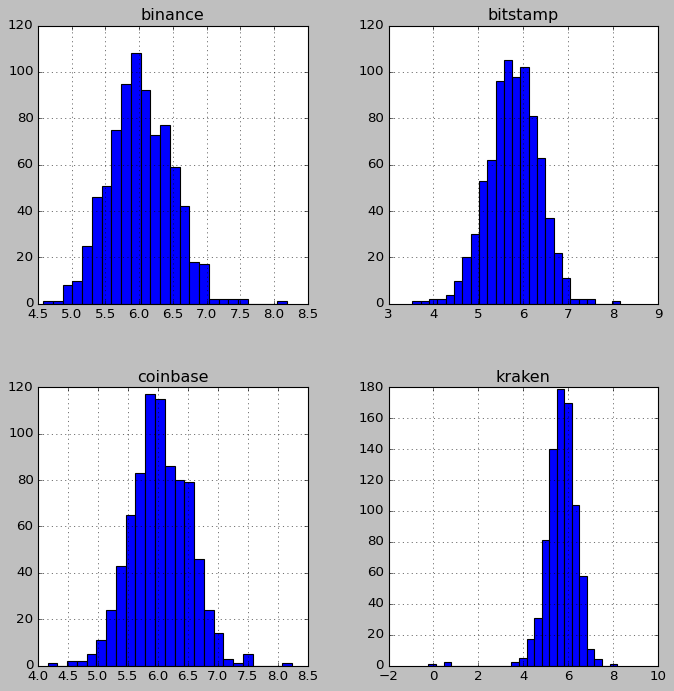

In [9]:
price_ranges = price_ranges[price_ranges > 0]
log_range = price_ranges.apply(np.log)
log_range.hist(bins = 25, figsize=(10,10))

# normality check
for name in names:
    print(name, "\n")
    print('Normal price range ===============')
    p1 = st.shapiro(price_ranges[name])
    p2 = st.normaltest(price_ranges[name])
    print(f'Shapiro_Wilk p-value = {p1[1]},   Pearson p-value = {p2[1]}')
    p1 = st.shapiro(log_range[name])
    p2 = st.normaltest(log_range[name])
    print('Log range ========================')
    print(f'Shapiro_Wilk p-value = {p1[1]},   Pearson p-value p-value = {p2[1]} \n')

### $Так\ как\ тест\ логарифмированных\ данных\ на\ нормальность\ не\ удался.$
### $ Попробуем\ анализировать\ распределения\ с\ помощью\ QQ-plot$
https://habr.com/ru/post/578754/


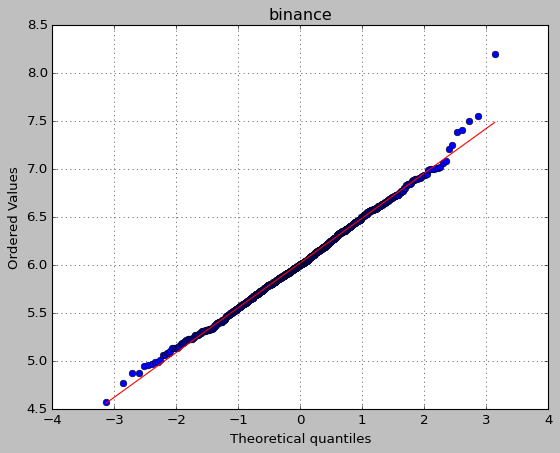

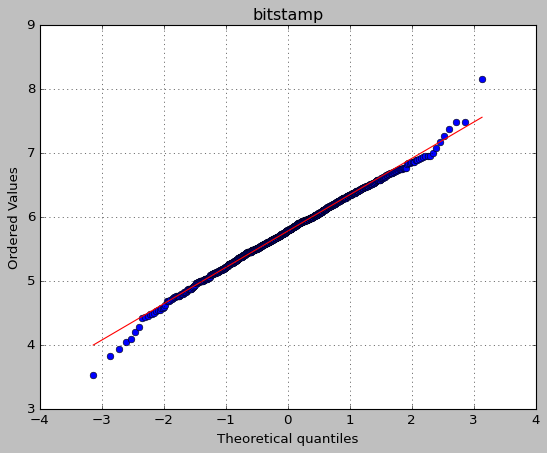

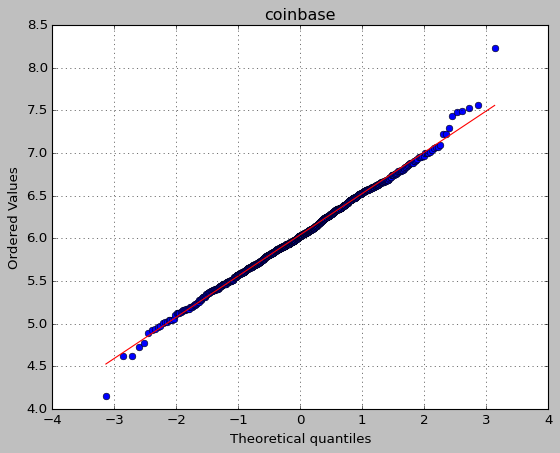

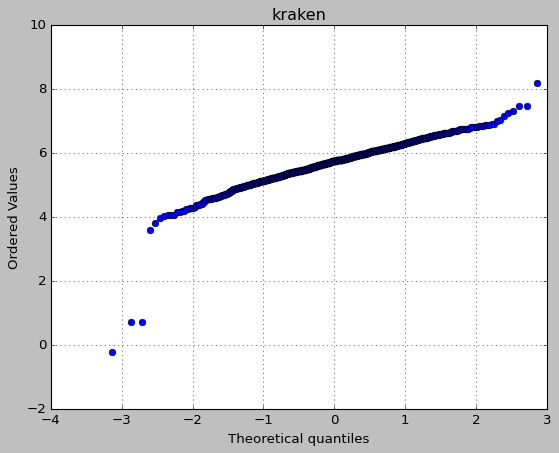

In [10]:
for name in names:
    st.probplot(log_range[name], dist="norm", plot=plt)
    plt.title(name)
    plt.grid()
    plt.show()

## Заключение
### $По\ QQ-plot\ можно\ заметить,\ что\ мы\ имеем\ дело\ с\ нормальным\ распределением\ с\ тяжелыми\ хвостами.$
### $Это\ достаточно\ типичное\ распределением\ для\ фондовых\ рынков.$
### $Одним\ из\ таких\ распределений\ является\ распределение\ Стьюдента.$

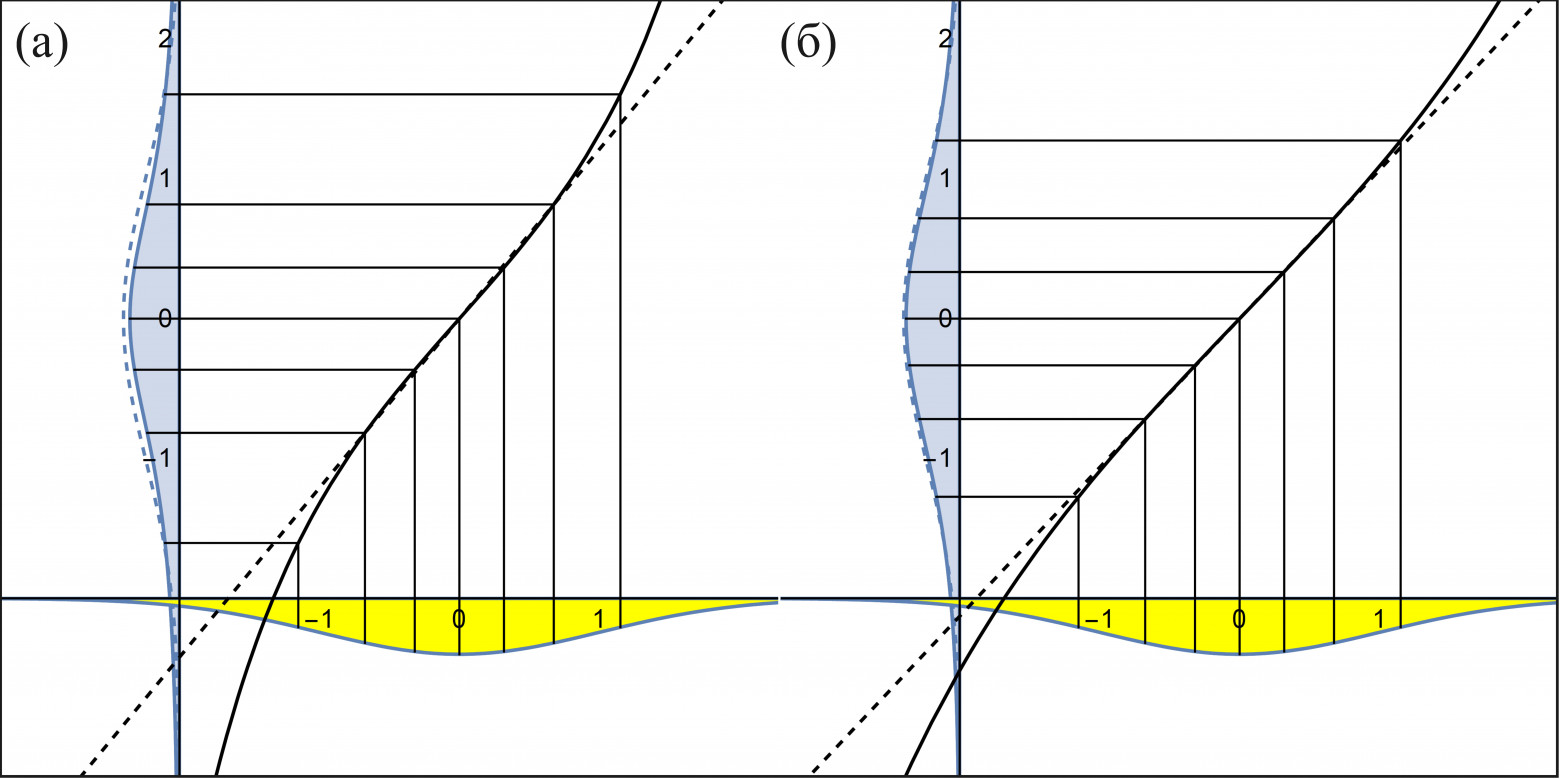

In [11]:
Image('QQ.jpg', width=200, height=100)